In [1]:
import os, sys
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import glob 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
from IPython.core.display import display, HTML    
display(HTML("<style>.container {width:98% !important; }</style>"))
%matplotlib inline
np.set_printoptions(precision=5, suppress=True) 

from datetime import datetime
DATE = datetime.now().strftime('%Y-%m-%d')

In [2]:
%load_ext rpy2.ipython

In [4]:
# PATHS
CREVIEW_CLASIF_FILE ="/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/chart_review/classif_report_chart_review1_2_3_vs_algo_labels.tsv"
CREVIEW_CONFM_FILE="/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/chart_review/conf_matrix_chart_review1_2_3_vs_algo_labels.tsv"

CONCOR_CLASIF_FILE="/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/ega_icd_concordance/classif_ega_vs_icd_labels.tsv"
CONCOR_CONFM_FILE="/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/ega_icd_concordance/conf_matrix_icd_ega_concord.tsv"

OUTPUT_DIR="/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/chart_review"

In [40]:
df = pd.read_csv("/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/chart_review/classif_report_chart_review1_2_3_vs_algo_labels.tsv")

In [41]:
df

,not-preterm preterm accuracy macro avg weighted avg
0,precision\t0.9875\t0.9583333333333334\t0.98076...
1,recall\t0.9875\t0.9583333333333334\t0.98076923...
2,f1-score\t0.9875\t0.9583333333333334\t0.980769...
3,support\t80.0\t24.0\t0.9807692307692307\t104.0...


In [53]:
# read clasif summary 
clf_df = pd.read_csv(CREVIEW_CLASIF_FILE, sep="\t",  index_col=0)
concor_clf = pd.read_csv(CONCOR_CLASIF_FILE, sep="\t", index_col=0)


clf_df.reset_index(inplace=True)
concor_clf.reset_index(inplace=True)



# conver wide to long 
clf_plt_df = pd.melt(clf_df, id_vars=['index'], value_vars=['not-preterm','preterm'])
conc_plt_df =  pd.melt(concor_clf, id_vars=['index'], value_vars=['not-preterm','preterm'])

In [32]:
# read confusion matrix
# rows := true labels; columns := predicted labels 
conf_df = pd.read_csv(CONCOR_CONFM_FILE, sep="\t", names=['true_label','pred_preterm','pred_not-preterm'], skiprows=1)
concor_conf = pd.read_csv(CREVIEW_CLASIF_FILE, sep="\t", names=['true_label','pred_preterm','pred_not-preterm'], skiprows=1)

In [55]:
conf_plt_df = pd.melt(conf_df, id_vars=['true_label'], value_vars=['pred_preterm','pred_not-preterm'])
conc_conf_plt_df =  pd.melt(concor_conf, id_vars=['true_label'], value_vars=['pred_preterm','pred_not-preterm'])

In [35]:
# round
clf_plt_df = clf_plt_df.round(2)
conc_plt_df = conc_plt_df.round(2)

# plot summaries

In [58]:
%%R 
library(ggplot2)
library(dplyr)
library(ggpubr)
library(cowplot)
library(forcats)

base_font_size = 10

In [59]:
# add count 
rename_dict = {'not-preterm': 'not-preterm\n(n=80)',
                'preterm': 'preterm\n(n=24)'}

rename_dict_conc = {'not-preterm': 'not-preterm\n(n=11,604)',
                'preterm': 'preterm\n(n=3,437)'}
clf_plt_df['delivery'] = clf_plt_df.variable.map(rename_dict)
conc_plt_df['delivery'] = conc_plt_df.variable.map(rename_dict_conc)

In [67]:
conc_plt_df.rename(columns={'index':'measure'},inplace=True)
clf_plt_df.rename(columns={'index':'measure'},inplace=True)

In [77]:
clf_plt_df.value = clf_plt_df.value.round(2)

In [93]:
%%R -i clf_plt_df -i OUTPUT_DIR -i DATE 

# plot PPV and Recall of Chart Review 
# no legend --> red is precision; blue is recall 
plt.df = clf_plt_df %>% filter( measure %in% c("precision","recall"))

plt.df$delivery = factor(plt.df$delivery, levels=c('preterm\n(n=24)', 'not-preterm\n(n=80)'))

plt = ggplot(plt.df, aes(x=delivery, y=value, fill=measure)) + geom_bar(stat='identity', position=position_dodge())
plt = plt +  theme_pubr(base_family="Arial", base_size=12) + theme(legend.position="none", plot.title = element_text(hjust = 0.5))

plt = plt + geom_text(stat='identity', aes(x=delivery, y=value, fill=measure, label=value, vjust=-0.1, hjust=0.5), position=position_dodge(0.9), size=3.5)
plt = plt + labs(fill = "",x="", title="Delivery Label Accuracy", y="")
plt = plt + scale_fill_brewer(palette="Set1")
                              
# plt                                
save.file=file.path(OUTPUT_DIR, sprintf('%s_chart_review_1_2_3_summary.pdf',DATE))
ggsave(save.file,plt,  device = cairo_pdf, height=3.75, width=4, units="in")


In [94]:
OUTPUT_DIR

'/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/chart_review'

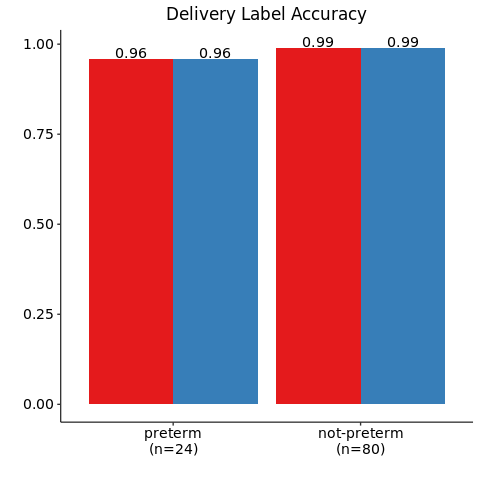

In [88]:
%%R 
plt

In [97]:
conc_plt_df.value = conc_plt_df.value.round(2)

In [108]:
%%R -i conc_plt_df -i OUTPUT_DIR -i DATE 

# plot PPV and Recall of Chart Review 
# no legend --> red is precision; blue is recall 
plt.df = conc_plt_df %>% filter( measure %in% c("precision","recall"))

plt.df$delivery = factor(plt.df$delivery, levels=c('preterm\n(n=3,437)', 'not-preterm\n(n=11,604)'))

plt = ggplot(plt.df, aes(x=delivery, y=value, fill=measure)) + geom_bar(stat='identity', position=position_dodge())
plt = plt + theme_pubr(base_family="Arial", base_size=12) + theme(legend.position="none", plot.title = element_text(hjust = 0.5))
plt = plt + geom_text(stat='identity', aes(x=delivery, y=value, fill=measure, label=value, vjust=-0.1, hjust=0.5), position=position_dodge(0.9),size=3.5)
plt = plt + labs(fill = "", x="", title="EGA and ICD-9 Concordance", y="") 
plt = plt + scale_fill_brewer(palette="Set1") 
                              

# save.file=file.path(OUTPUT_DIR, sprintf('%s_ega_icd_concord.pdf',DATE))
# ggsave(save.file,plt,  device = cairo_pdf, height=3.75, width=4, units="in")


In [109]:
%%R 
plot(g)


Error in set.gpar(x$gp) : argument must be a 'gpar' object
